Using the USDA FoodData Central API to compare food categories
- Pull 50 items from 5 categories


data.world link: https://data.world/lydsleepy/usda-nutrition-data

First, I'm importing everything I need to collect data with my API, as well as to analyze the data.

In [ ]:
# importing everything

# for the actual getting data
import requests
import pandas as pd
import time
from datetime import datetime

# for descriptive statistics and analysis things
import matplotlib.pyplot as plt
import seaborn as sns

I requested an API key, then set my key and the base URL as constant variables to use within my code.

In [ ]:
api_key = "XeQbGEzwfYOQQ5XDA6EL5ZAyuZCcpYeTHv3coBxZ"
base_url = "https://api.nal.usda.gov/fdc/v1/foods/search"

Next, I'll define a function to actually fetch the data from USDA FoodData Central. This function will be called in the main function.

In [ ]:
# defining function to fetch food data from USDA FoodData Central API
# query is the search term
#max_results is max num of food items to return, defaulted to 60
def fetch_category(query, max_results=60):
  all_foods = []
  page_size = 50 # max number of results returned in single request

  # dictionary of parameters that will be sent to the api
  params = {
      'api_key': api_key,
      'query': query,
      'pageSize': page_size,
      # which database to search
      # branded is commerical (like cheerios)
      # survey is generic (like "chicken breast, cooked")
      'dataType': ['Branded', 'Survey (FNDDS)']
  }

  print(f"Fetching {query} foods...")

  try:
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    # takes text response from api and turns it into python dictionary
    data = response.json()

    # looks for key called 'foods' in data dictionary
    # if it finds it, returns the list / if not, returns empty list
    foods = data.get('foods', [])
    # adds items in foods to the all_foods list
    all_foods.extend(foods[:max_results])
    print(f"Retrieved {len(foods[:max_results])} items")
  except Exception as e:
    print(f"Error fetching {query}: {e}")
  # waits half a second before continuing to not overwhelm api
  time.sleep(0.5)
  return all_foods

This next function will be to extract nutritional information for each food item. This will also be called in the main function.

In [ ]:
# defining function that extracts nutritional info from food item
def extract_nutrients(food_item):
  nutrients_dict = {}

  nutrients_dict['fdc_id'] = food_item.get('fdcId', '')
  # food name / description
  nutrients_dict['description'] = food_item.get('description', '')
  # like Chobani for yogurt
  nutrients_dict['brand_owner'] = food_item.get('brandOwner', 'N/A')
  nutrients_dict['data_type'] = food_item.get('dataType', '')
  nutrients_dict['food_category'] = food_item.get('foodCategory', 'N/A')

  # api will return nutrients as a list of dictionaries
  nutrients = food_item.get('foodNutrients', [])

  # dictionary
  # left side is what the api calls the nutrient
  # right side is what we call it in our csv
  nutrient_map = {
      'Energy': 'calories',
      'Protein': 'protein_g',
      'Total lipid (fat)': 'fat_g',
      'Carbohydrate, by difference': 'carbs_g',
      'Sugars, total including NLEA': 'sugar_g',
      'Fiber, total dietary': 'fiber_g',
      'Sodium, Na': 'sodium_mg',
      'Cholesterol': 'cholesterol_mg',
      'Fatty acids, total saturated': 'saturated_fat_g'
  }

  # makes sure every food has those columns (in nutrient_map) even if the
  # api didnt provide the value for it
  for key in nutrient_map.values():
    nutrients_dict[key] = None

  # extracts name and number from each nutrient
  for nutrient in nutrients:
    nutrient_name = nutrient.get('nutrientName', '')
    nutrient_value = nutrient.get('value', None)

    for search_name, dict_key in nutrient_map.items():
      # converts both to lowercase to handle case-insensitive
      if search_name.lower() in nutrient_name.lower():
        # saves nutrient value using our naming convention
        nutrients_dict[dict_key] = nutrient_value
        break

  return nutrients_dict

This will be the main function. It will call both of the functions already written and put everything together. This part of the code actually runs something.

In [ ]:
# defining main function that will collect the food data
def main():
  print("=" * 60)
  print("USDA FoodData Central - Nutrition Data Extractor")
  print("=" * 60)
  print()

  # high-protein foods ^_^
  categories = [
      'protein bars',
      'greek yogurt',
      'chicken breast',
      'cottage cheese',
      'tuna'
  ]

  # will store all the extracted nutrient data from all categories
  all_food_data = []

  # calls the fetch_category function we defined earlier
  for category in categories:
    foods = fetch_category(category, max_results=50)

    for food in foods:
      # extracts and organizes nutritional data
      # returns clean dictionary w info
      # stores it in a clean dictionary
      food_data = extract_nutrients(food)
      # takes dictionary and adds to master list
      all_food_data.append(food_data)

  # each dictionary becomes a row, each key becomes a column
  df = pd.DataFrame(all_food_data)

  # removes rows where calories & protein are both missing
  df = df.dropna(subset=['calories', 'protein_g'], how='all')

  print()
  print("=" * 60)
  print(f"Data collection complete!")
  print(f"\tTotal records: {len(df)}") # number of rows
  print(f"\tColumns: {len(df.columns)}") # number of columns
  print("=" * 60)
  print()

  # formats year/month/date_hour/minute/second
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  # creates filename
  filename_raw = f"usda_nutrition_data_raw_{timestamp}.csv"
  # index=False means not to include row numbers as a column
  df.to_csv(filename_raw, index=False)

  print(f"Raw data saved to: {filename_raw}")
  print()

  # protein to calorie ratio !!!!!!
  # look into lambda/anonymous functions later they seem interesting
  # only create column if both calories and protein exists
  if 'calories' in df.columns and 'protein_g' in df.columns:
    # df.apply applies a function to each row
    df['protein_per_calorie'] = df.apply(
      # divides protein by calories, rounding to 3 decimal places
      lambda row: round(row['protein_g'] / row['calories'], 3)

      # only calculates if calories exists (so we dont divide by 0)
      # if calories doesnt exist, set to None
      if pd.notna(row['calories']) and pd.notna(row['protein_g']) and row['calories'] > 0
      else None,
      axis=1
    )
    print("Added protein_per_calorie column")

    filename_processed = f"usda_nutrition_data_processed_{timestamp}.csv"
    df.to_csv(filename_processed, index=False)
    print(f"Processed data saved to: {filename_processed}")

  # for displaying sample
  print()
  print("Sample of collected data:")
  cols_to_show = ['description', 'calories', 'protein_g', 'carbs_g', 'fat_g']
  available_cols = [col for col in cols_to_show if col in df.columns]
  # selects only those 5 columns
  # .head(10) shows the first 10 rows
  print(df[available_cols].head(10))
  print()

  print(f"Data saved to: {filename_processed}")
  print()

  return df

if __name__ == "__main__":
  df = main()

USDA FoodData Central - Nutrition Data Extractor

Fetching protein bars foods...
Retrieved 50 items
Fetching greek yogurt foods...
Retrieved 50 items
Fetching chicken breast foods...
Retrieved 50 items
Fetching cottage cheese foods...
Retrieved 50 items
Fetching tuna foods...
Retrieved 50 items

Data collection complete!
	Total records: 250
	Columns: 14

Raw data saved to: usda_nutrition_data_raw_20251010_033355.csv

Added protein_per_calorie column
Processed data saved to: usda_nutrition_data_processed_20251010_033355.csv

Sample of collected data:
                                         description  calories  protein_g  \
0                                       PROTEIN BARS     333.0      37.00   
1                                       PROTEIN BARS     367.0      25.00   
2                                       PROTEIN BARS     333.0      37.00   
3                                       PROTEIN BARS     333.0      37.00   
4      Nutrition bar (Snickers Marathon Protein Bar)     41

This section can be uncommented to debug the code. It prints all of the column names to check for typos. I had an issue with the calories_to_protein column not showing up so I searched for the calories and protein_g categories in particular.

In [ ]:
'''
# debugging lol

df = pd.read_csv('usda_nutrition_data_20251010_031445.csv')

# prints all column names
print(df.columns.tolist())

# checks if calories and protein columns exist
print([col for col in df.columns if 'calor' in col.lower()])

print([col for col in df.columns if 'protein' in col.lower()])
'''

['fdc_id', 'description', 'brand_owner', 'data_type', 'food_category', 'calories', 'protein_g', 'fat_g', 'carbs_g', 'sugar_g', 'fiber_g', 'sodium_mg', 'cholesterol_mg', 'saturated_fat_g']
['calories']
['protein_g']


Here, we look at the descriptive statistics of our data.

In [ ]:
df = pd.read_csv('usda_nutrition_data_processed_20251010_033355.csv')

stats = df.describe()
print(stats)

             fdc_id    calories   protein_g      fat_g     carbs_g  sugar_g  \
count  2.500000e+02  250.000000  249.000000  250.00000  250.000000      0.0   
mean   2.478958e+06  186.748000   13.783574    7.35580   16.558960      NaN   
std    4.263917e+05  118.945114   10.471887    7.13208   21.568383      NaN   
min    3.735950e+05   40.000000    0.810000    0.00000    0.000000      NaN   
25%    2.216810e+06   97.000000    7.710000    2.23750    3.540000      NaN   
50%    2.705639e+06  142.500000   10.600000    4.63000    6.220000      NaN   
75%    2.706838e+06  242.250000   17.000000   10.30500   19.855000      NaN   
max    2.710745e+06  502.000000   78.130000   40.68000   79.170000      NaN   

          fiber_g    sodium_mg  cholesterol_mg  saturated_fat_g  \
count  249.000000   250.000000      250.000000       250.000000   
mean     1.316867   313.228000       27.212000         2.317952   
std      3.124261   199.104622       30.832086         2.547726   
min      0.000000   

Next, we will visualize our data.

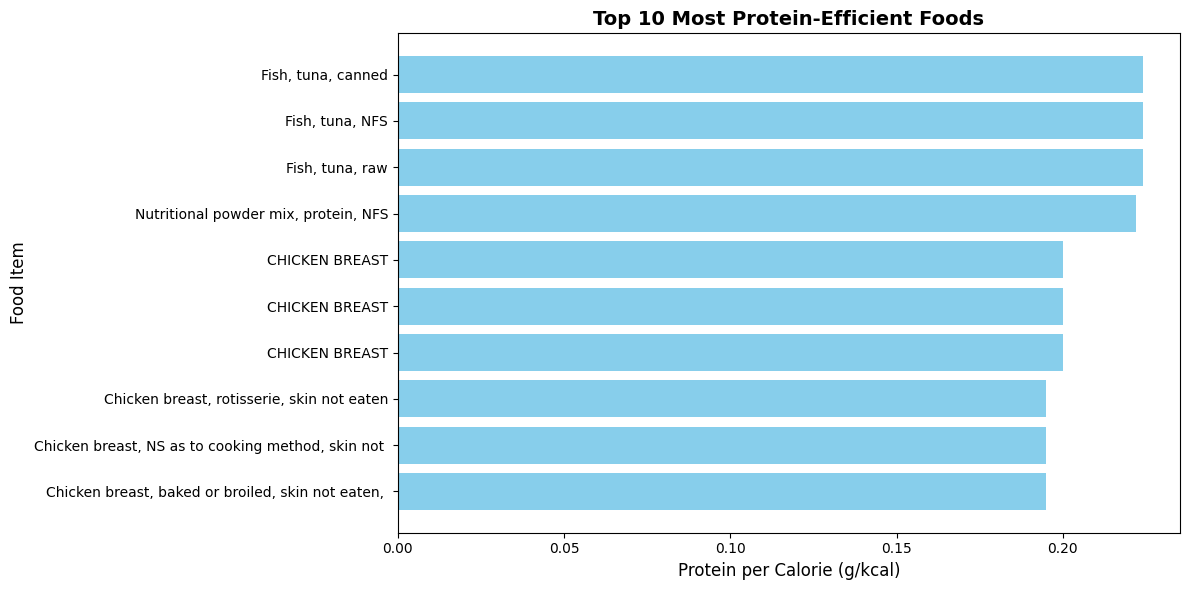


 These foods provie the most protein per calorie consumed.


In [ ]:
df_clean = df.dropna(subset=['protein_per_calorie'])

top_10 = df_clean.nlargest(10, 'protein_per_calorie')

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_10)), top_10['protein_per_calorie'], color='skyblue')
plt.yticks(range(len(top_10)), top_10['description'].str[:50])  # truncate long names
plt.xlabel('Protein per Calorie (g/kcal)', fontsize=12)
plt.ylabel('Food Item', fontsize=12)
plt.title('Top 10 Most Protein-Efficient Foods', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()

print("\n These foods provie the most protein per calorie consumed.")

**Analysis, Observations, and Insights:**
- The most efficient foods in terms of a protein-to-calorie ratio seem to be tuna, followed closely by a nutritional protein powder mix. Canned tuna takes the top spot, which makes sense since most of the fat has been rendered out of the fish by that point. If it is then stored in water, canned tuna becomes an extremely lean source of protein.
- The rest of the list is completely taken over by various types of chicken breast. This doesn't surprise me, as chicken breast is also known within the fitness community to be an extremely efficient source of lean protein.


Although protein powder is not the most efficient source that we pulled from the data, it is VERY close and an amazing option for those who don't want to eat straight canned tuna. After all, turning canned tuna into food items such as traditional tuna salad will add additional macronutrients and calories that are unaccounted for in this analysis.